### **Import all necessary Libraries**

In [72]:
!pip install xgboost

In [73]:
%matplotlib inline
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from scipy.stats import skew
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

### **Load DataSet**

In [74]:
#Used in google colabs
# !gdown --fuzzy https://drive.google.com/file/d/1iuhrtVJIhJ4xPlrNmUL570gBUoozB3YJ/view?usp=sharing 

In [86]:
NYPD_Smalldf = pd.read_csv('dataset/NYPD_cleaned_data.csv', low_memory=False, index_col = 0).sample(frac = 0.7,random_state=23)
NYPD_Smalldf = NYPD_Smalldf[(NYPD_Smalldf['BORO_NM'] != 'UNKOWN') & (NYPD_Smalldf['LOC_OF_OCCUR_DESC'] != 'UNKOWN')]

In [87]:
NYPD_Smalldf.shape


(19770, 29)

In [88]:
NYPD_Smalldf.head(2)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,...,Month_Abbr,Year,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
166203,195065730,2019-03-23,15:20:00,03/23/2019,DANGEROUS WEAPONS,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,BRONX,FRONT OF,...,Mar,2019,49.0,236.0,782.0,0.0,1021917.0,251014.0,6.907381e+12,-0.16099
132797,10958619,2006-04-07,18:00:00,04/07/2006,GRAND LARCENY,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",COMPLETED,FELONY,BRONX,INSIDE,...,Apr,2006,42.0,109.0,439.0,0.0,1012075.0,239818.0,6.864495e+12,-0.16099


### **Feature engineering**

In [89]:

NYPD_Smalldf['RPT_DT'] = pd.to_datetime(NYPD_Smalldf['RPT_DT'])
NYPD_Smalldf['RPT_YEAR'] = NYPD_Smalldf['RPT_DT'].dt.year
NYPD_Smalldf['RPT_MONTH'] = NYPD_Smalldf['RPT_DT'].dt.month
NYPD_Smalldf['RPT_DAY'] = NYPD_Smalldf['RPT_DT'].dt.day
NYPD_Smalldf['RPT_DAY_OF_WEEK'] = NYPD_Smalldf['RPT_DT'].dt.dayofweek
NYPD_Smalldf['RPT_IS_WEEKEND'] = NYPD_Smalldf['RPT_DAY_OF_WEEK'].isin([5, 6]).astype(int)


In [90]:
NYPD_Smalldf['CMPLNT_FR_DT'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_DT'])
NYPD_Smalldf['REPORT_DELAY'] = (NYPD_Smalldf['RPT_DT'] - NYPD_Smalldf['CMPLNT_FR_DT']).dt.days
NYPD_Smalldf['REPORT_DELAY'] = NYPD_Smalldf['REPORT_DELAY'].fillna(0).clip(lower=0)


In [91]:
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])
NYPD_Smalldf['Hour'] = NYPD_Smalldf['CMPLNT_FR_TM'].dt.hour
NYPD_Smalldf['Time_Category'] = NYPD_Smalldf['Hour'].apply(time_of_day)

C:\Users\IGHAL\AppData\Local\Temp\ipykernel_36952\3414940272.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])


In [92]:
NYPD_Smalldf.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'RPT_DT', 'OFNS_DESC',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'PATROL_BORO', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'Month_Abbr', 'Year', 'ADDR_PCT_CD', 'KY_CD', 'PD_CD',
       'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_DAY_OF_WEEK',
       'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour', 'Time_Category'],
      dtype='object')

### **Logistic regression - Multi Class Classification**

c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


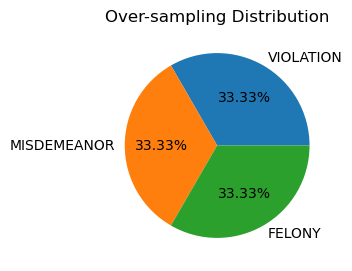

Mean cross-validation accuracy: 0.6482046947106685

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      2160
           1       0.54      0.44      0.49      2161
           2       0.58      0.56      0.57      2161

    accuracy                           0.64      6482
   macro avg       0.63      0.64      0.63      6482
weighted avg       0.63      0.64      0.63      6482

Confusion Matrix:
 [[2005   72   83]
 [ 423  960  778]
 [ 209  747 1205]]


In [93]:
x = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]

severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)



rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(x, y_ord)


unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]

plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()



# pipeline preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)



#Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=3000))
])


# train test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("LogisticRegression_confusion_matrix.png")



### **XGBOOST - Multi Class Classification**

c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


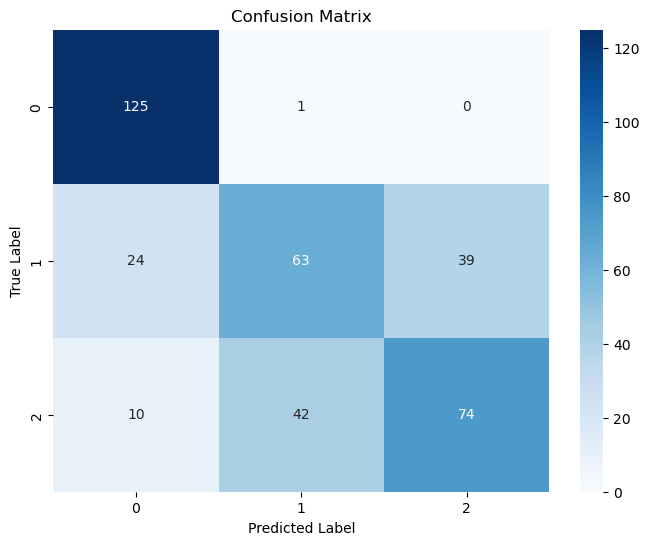

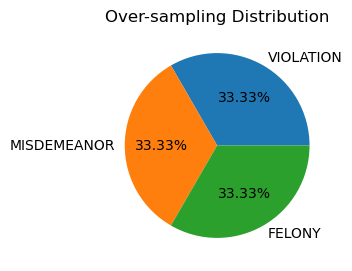

KeyboardInterrupt: 

In [71]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset. It performs data preprocessing,
applies oversampling to handle class imbalance, trains an XGBoost classifier, evaluates the model using cross-validation,
and generates a classification report and confusion matrix to assess the model's performance.
'''


x = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]




severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)





rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(x, y)


unique_labels, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()
plt.savefig("Over-sampling_Distribution.png")



# pipline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# ml pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss'))
])


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42, stratify=y_res)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("XGBOOST_confusion_matrix.png")


###  **Random Forest Classifier - Multi Class Classification**

In [ ]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset.This code performs data preprocessing,
applies oversampling to handle class imbalance, trains a Random Forest classifier,
evaluates the model with cross-validation, and generates a classification report and confusion matrix for performance assessment.
'''


x = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]




severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)


rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(x, y_ord)


unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()



preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)




pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])




X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("RandomForest_confusion_matrix.png")


### **Support Vector Machine - Multi Class Classification**

c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


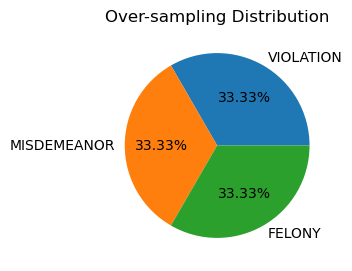

Mean cross-validation accuracy: 0.6675712347354138

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84        27
           1       0.47      0.54      0.50        28
           2       0.57      0.29      0.38        28

    accuracy                           0.60        83
   macro avg       0.59      0.61      0.57        83
weighted avg       0.59      0.60      0.57        83

Confusion Matrix:
 [[27  0  0]
 [ 7 15  6]
 [ 3 17  8]]


In [ ]:
'''
This code is focused on classifying the severity of crimes in the NYPD dataset.
It performs data preprocessing, applies oversampling to address class imbalance,
trains an SVM classifier using a pipeline with OneHotEncoding and StandardScaler,
evaluates the model using cross-validation, and visualizes the classification
results with a confusion matrix.
'''




x = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]


severity_order = {'VIOLATION': 0, 'MISDEMEANOR': 1, 'FELONY': 2}
y_ord = NYPD_Smalldf['LAW_CAT_CD'].map(severity_order)



rus = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_res, y_res = rus.fit_resample(x, y_ord)



unique_labels_encoded, counts = np.unique(y_res, return_counts=True)
original_labels = [key for key, value in severity_order.items()]

plt.figure(figsize=(3, 3))
plt.pie(counts, labels=original_labels, autopct='%.2f%%')
plt.title("Over-sampling Distribution")
plt.show()






preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols) ],remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', kernel='rbf', C=1))
])


X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Mean cross-validation accuracy:", cv_accuracy)



print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Support Vector Machine')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("SVM_confusion_matrix.png")


### **Logistic Regression, SVM , Random Forest, XGBoost - Binary Classification**
#### *This was used in the comparative analysis*

### **Data Preprocessing**

In [97]:
'''
Defines the features the algorithms will use  
Resolves imbalance in the dataset through oversampling
'''


'''
Feature test 1
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
                         'BORO_NM', 'SUSP_SEX', 'SUSP_AGE_GROUP', 
                         'REPORT_DELAY', 'Y_COORD_CD']].copy()


categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
                    'BORO_NM', 'SUSP_SEX', 'SUSP_AGE_GROUP']
numeric_cols = ['REPORT_DELAY', 'Y_COORD_CD']
'''



'''
#Feature test 2
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]
'''



y_binary = NYPD_Smalldf['LAW_CAT_CD'].map(lambda x: 1 if x == 'FELONY' else 0)


'''
# Feature Test 3
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 
                         #'ADDR_PCT_CD', 
                         'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  'KY_CD', 
                  #'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude',
                  #'JURISDICTION_CODE',
                  
                  #'Month_Abbr',
                  #'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  #'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour'
                  ]]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    #'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    #'Month_Abbr'
                    ]

numeric_cols = [
    #'ADDR_PCT_CD',
    'KY_CD',
    #'PD_CD',
    'Latitude', 'Longitude', 
    #'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    #'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]

'''





# Feature  Test 4

X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  #'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    #'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]


X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y_binary,
    test_size=0.20,
    random_state=42,
    stratify=y_binary, 
)

ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)


c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### **Classical Models**


 Evaluating: Support Vector Machine
Mean cross-validation accuracy: 0.6933

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      2201
           1       0.67      0.79      0.72      2200

    accuracy                           0.70      4401
   macro avg       0.71      0.70      0.70      4401
weighted avg       0.71      0.70      0.70      4401

Confusion Matrix:
[[1339  862]
 [ 463 1737]]


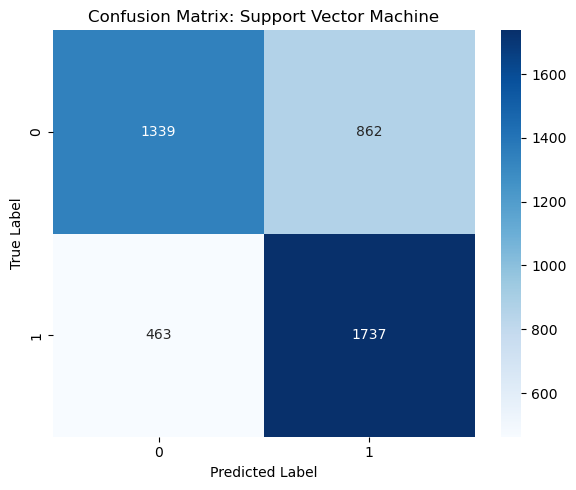


 Evaluating: Random Forest
Mean cross-validation accuracy: 0.9340

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2201
           1       0.95      0.95      0.95      2200

    accuracy                           0.95      4401
   macro avg       0.95      0.95      0.95      4401
weighted avg       0.95      0.95      0.95      4401

Confusion Matrix:
[[2086  115]
 [ 111 2089]]


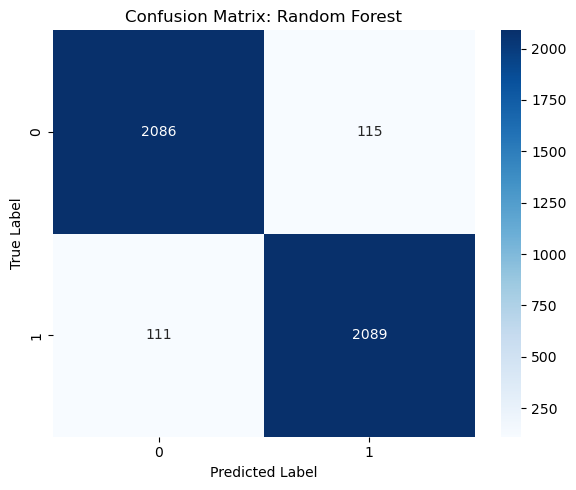


 Evaluating: XGBoost


c:\Users\IGHAL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\IGHAL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\IGHAL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\IGHAL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Mean cross-validation accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2201
           1       1.00      1.00      1.00      2200

    accuracy                           1.00      4401
   macro avg       1.00      1.00      1.00      4401
weighted avg       1.00      1.00      1.00      4401

Confusion Matrix:
[[2193    8]
 [   1 2199]]


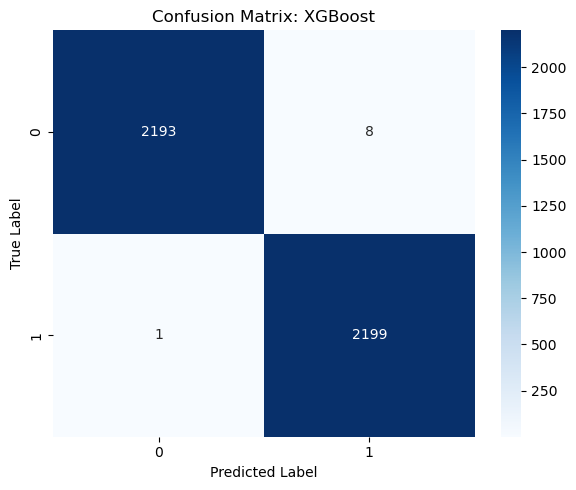


 Evaluating: Logistic Regression
Mean cross-validation accuracy: 0.6272

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      2201
           1       0.62      0.66      0.64      2200

    accuracy                           0.62      4401
   macro avg       0.62      0.62      0.62      4401
weighted avg       0.62      0.62      0.62      4401

Confusion Matrix:
[[1291  910]
 [ 745 1455]]


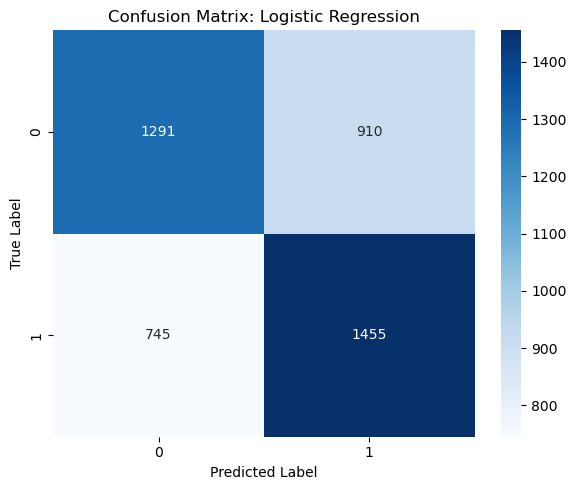

In [98]:
# Define models you want to compare
models = {
    'Support Vector Machine': SVC(class_weight='balanced', kernel='rbf', C=1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=3000)
}

# Preprocessor stays the same
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)

# Split your data once
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res,
)


# Loop through models and evaluate each one
for name, model in models.items():
    print(f"\n Evaluating: {name}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f"Mean cross-validation accuracy: {cv_accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
